# Algoritmo 2 - Agrupamento (Clustering)


## Introdução
Exploramos atributos técnicos e físicos de jogadores e jogadoras do EA FC 24 para identificar padrões de semelhança com `KMeans`.
A análise centra-se em atletas de campo e procura responder: quantos segmentos coerentes existem, que características definem cada grupo e como se distribuem o género e a posição.


## Objetivo do notebook
Este caderno consolida o método de agrupamento aplicado aos jogadores do FC 24.
Inclui preparação do ambiente, ingestão e limpeza dos dados, seleção de atributos, avaliação de `k` e análise qualitativa dos clusters com apoio de PCA, tabelas e visualizações.


### Preparação do ambiente
Instala as dependências necessárias diretamente no kernel para garantir versões alinhadas para `numpy`, `pandas`, `matplotlib` e `mlxtend`.


In [1]:
from sys import prefix

print("Olá Mundo!")

%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install mlxtend


Olá Mundo!
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Carregamento e consolidação dos dados
Lemos os ficheiros femininos e masculinos do EA FC, adicionamos o campo `genero` e criamos um `DataFrame` único filtrado para a versão 24 do jogo.


In [2]:
import pandas as pd

# Carregar datasets e adicionar coluna de género
jogadores_masculinos = pd.read_csv("Data/EA_FC/male_players.csv", low_memory=False)
jogadoras_femininas = pd.read_csv("Data/EA_FC/female_players.csv")

jogadores_masculinos["genero"] = "M"
jogadoras_femininas["genero"] = "F"

jogadores = pd.concat([jogadores_masculinos, jogadoras_femininas], ignore_index=True)

# Manter apenas registos da versão FC 24
jogadores_24 = jogadores[jogadores["fifa_version"] == 24].copy()



### Agrupamento de posições e filtro de jogadores
Convertimos `player_positions` em grupos agregados (GR/DEF/MED/ATA) e mantemos apenas defesas, médios e avançados para estudar perfis de atletas de campo.


In [3]:
# Mapear posição principal para grupos macro
def mapear_grupo_posicao(posicoes_str: str) -> str:
    if pd.isna(posicoes_str):
        return "OUTRO"
    posicao_principal = posicoes_str.split(",")[0].strip()
    # Grupos macro para reduzir classes
    defesas = {"CB", "LB", "RB", "LWB", "RWB"}
    medios = {"CDM", "CM", "CAM", "LM", "RM"}
    avancados = {"ST", "CF", "LW", "RW"}

    if posicao_principal == "GK":
        return "GR"
    elif posicao_principal in defesas:
        return "DEF"
    elif posicao_principal in medios:
        return "MED"
    elif posicao_principal in avancados:
        return "ATA"
    else:
        return "OUTRO"


# Obter todos os grupos presentes nas posições do jogador
def conjunto_grupos_posicao(posicoes_str: str) -> set:
    if pd.isna(posicoes_str):
        return set()
    defesas = {"CB", "LB", "RB", "LWB", "RWB"}
    medios = {"CDM", "CM", "CAM", "LM", "RM"}
    avancados = {"ST", "CF", "LW", "RW"}

    grupos = set()
    for pos in posicoes_str.split(","):
        p = pos.strip()
        if p == "GK":
            grupos.add("GR")
        elif p in defesas:
            grupos.add("DEF")
        elif p in medios:
            grupos.add("MED")
        elif p in avancados:
            grupos.add("ATA")
        else:
            grupos.add("OUTRO")
    return grupos


jogadores_24["grupo_posicao"] = jogadores_24["player_positions"].apply(mapear_grupo_posicao)

# Manter apenas jogadores de campo (exclui GR e OUTRO)
jogadores_24_campo = jogadores_24[jogadores_24["grupo_posicao"].isin(["DEF", "MED", "ATA"])].copy()

# Manter apenas jogadores com posições de um único grupo (menos ambiguidade)
jogadores_24_campo["conjunto_grupos"] = jogadores_24_campo["player_positions"].apply(conjunto_grupos_posicao)
jogadores_24_campo["conjunto_grupos_limpo"] = jogadores_24_campo["conjunto_grupos"].apply(
    lambda s: {g for g in s if g in {"DEF", "MED", "ATA"}}
)
jogadores_24_campo = jogadores_24_campo[
    jogadores_24_campo["conjunto_grupos_limpo"].apply(len) == 1
].copy()



### Seleção de atributos e normalização
Usamos apenas métricas detalhadas (attacking/skill/movement/power/mentality/defending) para alimentar o agrupamento. Mantemos apenas jogadores cujas posições listadas ficam no mesmo grupo (DEF/MED/ATA) para reduzir ruído, removemos linhas com `NaN` e aplicamos `StandardScaler` para colocar todas as escalas no mesmo patamar.



In [4]:
# Selecionar apenas atributos de jogo (por prefixo)
prefixos_detalhe = (
    "attacking_",
    "skill_",
    "movement_",
    "power_",
    "mentality_",
    "defending_",
)
# Colunas ordenadas por prefixo para consistência
colunas_atributos = sorted(
    [c for c in jogadores_24_campo.columns if c.startswith(prefixos_detalhe)]
)

# Filtrar jogadores com atributos completos
dados_cluster = jogadores_24_campo.dropna(subset=colunas_atributos).copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preparar matriz numérica para agrupamento
matriz_atributos = dados_cluster[colunas_atributos].values

# A normalização por género é feita mais abaixo



In [5]:
# Distribuição do dataset por género e posição
# Ajuda a verificar desequilíbrio antes do agrupamento
contagens_pos_genero = pd.crosstab(jogadores_24_campo["grupo_posicao"], jogadores_24_campo["genero"])
print("jogadores_24_campo: grupo_posicao x género")
print(contagens_pos_genero)
print("jogadores_24_campo: proporções por grupo_posicao")
print(contagens_pos_genero.div(contagens_pos_genero.sum(axis=1), axis=0).round(3))

contagens_pos_genero_cluster = pd.crosstab(dados_cluster["grupo_posicao"], dados_cluster["genero"])
print("dados_cluster: grupo_posicao x género (após dropna)")
print(contagens_pos_genero_cluster)
print("dados_cluster: proporções por grupo_posicao")
print(contagens_pos_genero_cluster.div(contagens_pos_genero_cluster.sum(axis=1), axis=0).round(3))



jogadores_24_campo: grupo_posicao x género
genero           F     M
grupo_posicao           
ATA            288  2480
DEF            506  5052
MED            516  4883
jogadores_24_campo: proporções por grupo_posicao
genero             F      M
grupo_posicao              
ATA            0.104  0.896
DEF            0.091  0.909
MED            0.096  0.904
dados_cluster: grupo_posicao x género (após dropna)
genero           F     M
grupo_posicao           
ATA            288  2480
DEF            506  5052
MED            516  4883
dados_cluster: proporções por grupo_posicao
genero             F      M
grupo_posicao              
ATA            0.104  0.896
DEF            0.091  0.909
MED            0.096  0.904


### Escolha de k e criação dos clusters
Testamos valores de `k` entre 3 e 7 guardando a inércia e a *silhouette*. O `KMeans` final usa o `k` que maximiza a *silhouette* e avaliamos a precisão pelo mapeamento de maioria para `grupo_posicao`.



In [6]:
from IPython.display import display
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
import numpy as np

# Normalizar por género para evitar escalas diferentes entre M/F
atributos_norm_genero = np.zeros_like(matriz_atributos, dtype=float)
for genero in dados_cluster["genero"].unique():
    idx = dados_cluster["genero"] == genero
    scaler_genero = StandardScaler()
    atributos_norm_genero[idx.values] = scaler_genero.fit_transform(matriz_atributos[idx.values])

# Avaliar vários k por silhouette e devolver etiquetas do melhor
def avaliar_kmeans(atributos_norm, valores_k):
    inercias = []
    silhuetas = []

    for k in valores_k:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        etiquetas = kmeans.fit_predict(atributos_norm)
        inercias.append(kmeans.inertia_)
        silhuetas.append(silhouette_score(atributos_norm, etiquetas))

    melhor_k = valores_k[silhuetas.index(max(silhuetas))]
    kmeans = KMeans(n_clusters=melhor_k, random_state=42, n_init="auto")
    melhores_etiquetas = kmeans.fit_predict(atributos_norm)

    return melhor_k, inercias, silhuetas, melhores_etiquetas


# Mapear cluster -> posição dominante (voto maioritário)
def precisao_mapeamento_maioria(etiquetas_reais, etiquetas_cluster):
    mapeamento = (
        pd.DataFrame({"cluster": etiquetas_cluster, "posicao": etiquetas_reais})
        .groupby("cluster")["posicao"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    previsoes = pd.Series(etiquetas_cluster, index=etiquetas_reais.index).map(mapeamento)
    precisao = (previsoes == etiquetas_reais).mean()
    return precisao, mapeamento, previsoes


# Intervalo de k a testar
valores_k = list(range(3, 8))

melhor_k, inercias, silhuetas, etiquetas = avaliar_kmeans(atributos_norm_genero, valores_k)

etiquetas_reais = dados_cluster["grupo_posicao"]

# Métricas de alinhamento com posição real
ari = adjusted_rand_score(etiquetas_reais, etiquetas)
nmi = normalized_mutual_info_score(etiquetas_reais, etiquetas)
precisao, mapeamento, previsoes = precisao_mapeamento_maioria(etiquetas_reais, etiquetas)

print("Atributos normalizados por género")
print(f"Melhor k por silhouette: {melhor_k}")
print(f"Precisão detalhada (mapa de maioria): {precisao:.2%}")
print(f"ARI: {ari:.4f} | NMI: {nmi:.4f}")

# Mapeamento cluster -> posição dominante (interpretação)
display(mapeamento)

# Guardar etiquetas e previsões no dataframe
dados_cluster["cluster"] = etiquetas
dados_cluster["posicao_prevista"] = previsoes

# Matriz de confusão normalizada por posição real
matriz_confusao_posicao = pd.crosstab(
    dados_cluster["grupo_posicao"],
    dados_cluster["posicao_prevista"],
    normalize="index",
).round(3)


display(matriz_confusao_posicao)

estatisticas_cluster = dados_cluster.groupby("cluster")[colunas_atributos].mean()

contagens_genero = dados_cluster.groupby(["cluster", "genero"]).size().unstack(fill_value=0)
proporcoes_genero = contagens_genero.div(contagens_genero.sum(axis=1), axis=0)



Atributos normalizados por género
Melhor k por silhouette: 3
Precisão detalhada (mapa de maioria): 69.19%
ARI: 0.3288 | NMI: 0.3442


cluster
0    ATA
1    DEF
2    MED
Name: posicao, dtype: object

posicao_prevista,ATA,DEF,MED
grupo_posicao,,,
ATA,0.823,0.002,0.175
DEF,0.012,0.751,0.237
MED,0.287,0.149,0.564


### Silhouette score por k
O grafico mostra a evolucao do silhouette score para cada k testado.


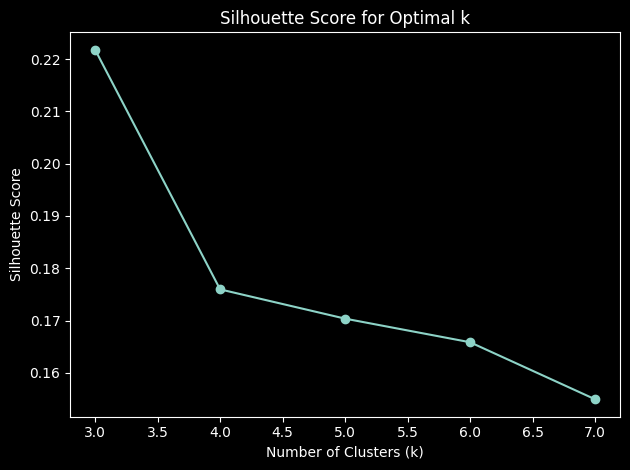

In [13]:
import matplotlib.pyplot as plt

k_values = valores_k
silhouette_scores = silhuetas

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.tight_layout()
plt.show()


### Projeção em 2D com PCA
Aplicamos PCA para reduzir as componentes e visualizar a separação dos clusters em duas dimensões, facilitando a interpretação visual da segmentação.


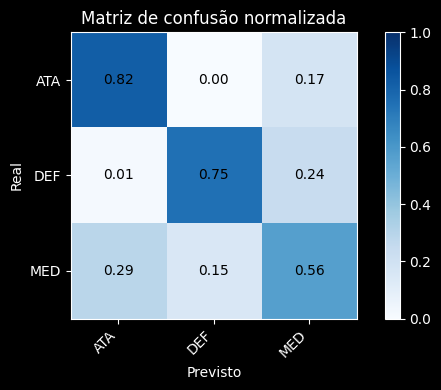

In [8]:
import matplotlib.pyplot as plt

# Heatmap da matriz de confusão normalizada
matriz_confusao = matriz_confusao_posicao.values
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(matriz_confusao, cmap="Blues", vmin=0, vmax=1)

ax.set_xticks(range(matriz_confusao.shape[1]))
ax.set_yticks(range(matriz_confusao.shape[0]))
ax.set_xticklabels(matriz_confusao_posicao.columns)
ax.set_yticklabels(matriz_confusao_posicao.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(matriz_confusao.shape[0]):
    for j in range(matriz_confusao.shape[1]):
        ax.text(j, i, f"{matriz_confusao[i, j]:.2f}", ha="center", va="center", color="black")

ax.set_xlabel("Previsto")
ax.set_ylabel("Real")
ax.set_title("Matriz de confusão normalizada")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



### Estatísticas médias por cluster
Geramos uma tabela com a média de cada atributo nas diferentes etiquetas para interpretar as características dominantes de cada segmento.


In [9]:
# Médias por cluster para interpretar perfis médios
medias_cluster = dados_cluster.groupby("cluster")[colunas_atributos].mean().round(1)
medias_cluster



,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,defending_marking_awareness,defending_sliding_tackle,defending_standing_tackle,mentality_aggression,mentality_composure,...,power_long_shots,power_shot_power,power_stamina,power_strength,skill_ball_control,skill_curve,skill_dribbling,skill_fk_accuracy,skill_long_passing,skill_moves
cluster,,,,,,,,,,,,,,,,,,,,,
0,49.9,61.2,54.0,59.7,53.1,30.5,29.6,31.9,48.7,58.1,...,56.5,62.3,60.6,61.3,63.9,51.9,63.5,46.9,50.2,2.7
1,44.7,33.2,59.9,58.9,32.0,62.1,62.3,64.6,63.6,55.3,...,34.6,46.9,64.8,70.0,56.4,39.4,50.1,34.7,53.0,2.0
2,63.2,58.0,58.7,71.3,53.4,60.6,59.5,63.0,66.9,68.3,...,61.8,67.3,74.5,67.2,71.1,62.7,69.2,56.8,67.2,2.8


### Distribuição de posições dentro de cada cluster
Calculamos contagens e proporções por `grupo_posicao` para verificar se há clusters dominados por defesas, médios ou avançados.


In [10]:
# Proporções por posição dentro de cada cluster
contagens_posicao = dados_cluster.groupby(["cluster", "grupo_posicao"]).size().unstack(fill_value=0)
proporcoes_posicao = contagens_posicao.div(contagens_posicao.sum(axis=1), axis=0)
proporcoes_posicao



grupo_posicao,ATA,DEF,MED
cluster,,,
0,0.585153,0.017467,0.397380
1,0.001003,0.837247,0.161750
2,0.100021,0.271809,0.628171


### Análise de género por cluster
Usamos `crosstab` para obter contagens e proporções de homens e mulheres em cada cluster, avaliando possíveis enviesamentos de género.


In [11]:
# Distribuição de género por cluster (contagem e proporção)
# Tabela cluster x género
contagens_genero_cluster = pd.crosstab(dados_cluster["cluster"], dados_cluster["genero"])
print(contagens_genero_cluster)

# Proporções dentro de cada cluster
proporcoes_genero_cluster = contagens_genero_cluster.div(contagens_genero_cluster.sum(axis=1), axis=0)
print(proporcoes_genero_cluster)



genero     F     M
cluster           
0        380  3513
1        499  4484
2        431  4418
genero          F         M
cluster                    
0        0.097611  0.902389
1        0.100140  0.899860
2        0.088884  0.911116


### Visualizações PCA segmentadas por cluster e género
As figuras seguintes reforçam a leitura dos clusters no espaço 2D, primeiro distinguindo rótulos e géneros simultaneamente e depois apenas por género para identificar sobreposições.


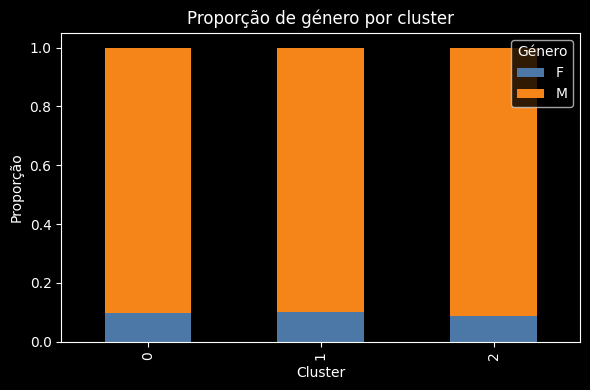

In [12]:
import matplotlib.pyplot as plt

# Distribuição de género por cluster (barras empilhadas)
proporcoes_genero_cluster.plot(kind="bar", stacked=True, figsize=(6, 4), color=["#4C78A8", "#F58518"])
plt.title("Proporção de género por cluster")
plt.xlabel("Cluster")
plt.ylabel("Proporção")
plt.legend(title="Género", loc="best")
plt.tight_layout()
plt.show()



## Conclusão
Os resultados mostram que o agrupamento captura perfis de jogo distintos, combinando velocidade, técnica e força, o que ajuda a descrever arquétipos de jogadores e jogadoras em campo.
A distribuição por posição confirma que os clusters não se limitam a uma única função, mas evidenciam tendências claras em certos segmentos (por exemplo, maior concentração de médios).
A projeção via PCA sugere separação razoável entre clusters, com alguma sobreposição natural entre estilos próximos e diferenças de escala entre géneros mitigadas pela normalização.
Como evolução, faz sentido testar modelos probabilísticos (e.g., GMM), incluir atributos físicos adicionais e avaliar a estabilidade dos clusters por liga ou época.
